# Result analysis of the web crawler

In this notebook, the dataframe filled with the cookies that were scraped using the webcrawler is analysed to gather what kind of information is saved by webpages upon arrival and after accepting the cookies. 


### Importing packages and the dataframe

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import ast
import urllib.request
import requests
import re

df = pd.read_csv('assets/DataFrame.csv', converters={"Host": ast.literal_eval,
                                                     "cookie_first": ast.literal_eval,
                                                     "cookie_second": ast.literal_eval
                                                     })

### Some statistics about the amount of websites

{'arrival': 6765, 'accepted': 3837, 'both': 3691}
146


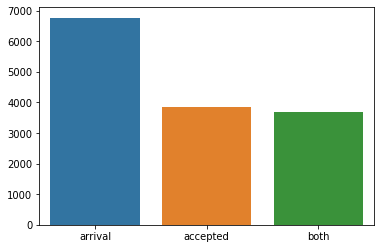

In [2]:
count = {'arrival': 0, 'accepted': 0, 'both': 0}

for index, row in df.iterrows():
    if (len(row['cookie_first']) > 0) & (len(row['cookie_second']) > 0):
        count['both'] += 1
    if len(row['cookie_first']) > 0:
        count['arrival'] += 1
    if len(row['cookie_second']) > 0:
        count['accepted'] += 1

sns.barplot(x=list(count.keys()), y=list(count.values()))
print(count)
print(count['accepted']-count['both'])


So far we see that **7350** websites created a cookie upon visiting, for **3436** websites, the crawler found a website and was able to accept the cookies, and lastly for **3123** websites both cookies were saved. This means that **313** websites that did save after confirmation did not make a cookie at first.

In [3]:
total = 0
for name in df['banner_provider'].unique():
    tmp = len(df[df['banner_provider'] == name])
    total += tmp
    print(name, tmp)
print('total', total)

nan 0
Unknown 228
OneTrust 294
Cybot 57
TrustArc 39
total 618


In [4]:
len(df[(df['options_available'] == True) & (df['banner_provider'] == 'Unknown')])

228

### Visiting cookie analysis

In [5]:
# Some functions that help to explore the list of cookies fast
def print_cookies(this_df):
    for index, row in this_df.iterrows():
        cookie = row['cookie_first'][0]
        print(row['Website'])
        for key, value in cookie.items():
            print(key, '=', value)
        print('')
        
def get_names(this_df, c):
    unique_names = []

    for index, row in this_df.iterrows():
        if c == 1:
            cookie = row['cookie_first'][0]
        if c == 2:
            cookie = row['cookie_second'][0]
        if cookie == None:
            continue
        for key, value in cookie.items():
            if key == 'name':
                if value not in unique_names:
                    unique_names.append(value)
    return unique_names

In [6]:
a_df = df[df['cookie_first'].apply(lambda x: len(x) > 0)]

# print_cookies(a_df)

In [7]:
names = get_names(a_df, 1)
print("Found {} unique cookie names".format(len(names)))

Found 2565 unique cookie names


So now we have an overview of the cookies and their 'unique' names. Let's see if we can filter out some keywords like _'gtag', 'session', 'geo', 'fbp', 'id', 'gdpr', 'consent'_

In [8]:
key_words = {
    'gtag': [], # Google Tag
    'gat': [], # Google Analytics
    '_ga': [], # Google Analytics
    'gtm': [], # Google Tag Manager
    '__auc': [], # Targeting/Advertising 
    'session': [], 
    'geo': [], # Location
    'fbp': [], # Facebook Pixel
    'id': [], # Identifier
    'gdpr': [], 
    'consent': [], 
    'cookie': []
}


no_id = []
for index, row in a_df.iterrows():
    cookie = row['cookie_first'][0]
    for key, value in cookie.items():
        if key == 'name':
            found = False
            for word in key_words.keys():
                if word in value.lower():
                    key_words[word].append(cookie)
                    found = True
                    continue
            if not found:
                no_id.append(value.lower())

no_count = {}
for name in no_id:
    if name in no_count.keys():
        no_count[name] += 1
    else:
        no_count[name] = 1
                
# Print the counts
for key, value in key_words.items():
    print(key, ':', len(key_words[key]))
    
no_count = {k: v for k, v in sorted(no_count.items(), key=lambda item: item[1], reverse=True)}
print(len(no_count))

gtag : 296
gat : 1316
_ga : 1522
gtm : 104
__auc : 33
session : 247
geo : 30
fbp : 475
id : 1610
gdpr : 5
consent : 127
cookie : 66
1212


In [9]:
def get_cookie_stats(url):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    try:
        request=urllib.request.Request(url,None,headers)
        response = urllib.request.urlopen(request)
        data = str(response.read())
        if "no matches" in data:
            return False
        elif "not yet any general information" in data:
            return False
        else:
            return data  
    except Exception as e:
        print(e)
        return False  

In [10]:
cookie_stats = pd.DataFrame(columns=['name', 
                                     'use', 
                                     'websites', 
                                     'hosts', 
                                     'first_party', 
                                     'third_party', 
                                     'persistent', 
                                     'life_span', 
                                     'session'])

In [ ]:
error_count = 0
try:
    for name in tqdm(no_count.keys()):
        if name not in list(cookie_stats['name']):
    #         print(name, end=': ')
            url = 'https://cookiepedia.co.uk/cookies/' + name

            data = get_cookie_stats(url)

            if data == False:
                error_count += 1
                continue

            ps = re.split('<p>|</p>', data)
            matching = [p for p in ps if 'main purpose' in p]
            usage = re.split('<strong>|</strong>', matching[0])[1]

            stats = re.split('<div class="cookie-stats">|</div>', data)[8]
            stats = re.split('<span>|</span>', stats)

            c_s = []
            if len(stats) > 13:
                c_s.append(name)
                c_s.append(usage)
                c_s.append(stats[1]) 
                c_s.append(stats[3])
                c_s.append(stats[5])
                c_s.append(stats[7])
                c_s.append(stats[9])
                c_s.append(stats[11])
                c_s.append(stats[13])
                cookie_stats.loc[len(cookie_stats)] = c_s
            else:
                print("not enough", name)


    #         print(usage)
except KeyboardInterrupt:
    print("Stopped Early")

HTTP Error 404: Not Found


In [ ]:
cookie_stats['use'].unique()

In [ ]:
toplen = len(cookie_stats[cookie_stats['websites'] > 5000])
top50 = cookie_stats.nlargest(toplen, 'websites')
sns.barplot(x=top50['name'], y=top50['websites'])


toplen

In [ ]:
columns = ['websites', 'hosts', 'first_party', 'third_party',
       'persistent', 'life_span', 'session']

for c in columns:
    if cookie_stats[c].dtype != 'int':
        cookie_stats[c] = cookie_stats[c].apply(lambda x: x.replace(',', ''))
        cookie_stats[c] = cookie_stats[c].astype('int')

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode()

import plotly.io as pio
pio.templates

import plotly.express as px


for column in list(top50.columns[2:]):
    top50 = cookie_stats.nlargest(25, column)
    fig = px.bar(top50,
                     x='name', y=column, color='use',
                     template='ggplot2', title="Column '%s' cookies" % column)
    fig.show()


### Accepted cookies

In [ ]:
b_df = df[df['cookie_second'].apply(lambda x: len(x) > 0)]
b_df = b_df[b_df['cookie_second'] != {'cookie': None}]
second_names = get_names(b_df, 2)
second_names = [n.lower() for n in second_names]

In [ ]:
patterns = {}
for name in second_names:
    split = name.split('_')
    if len(split) > 1:
        p = split[0]
        i = 0
        while p == '':
            i += 1
            p = split[i]
    else:
        p = name
    if p not in patterns.keys():
        patterns[p] = 1
    else:
        patterns[p] += 1
        
patterns = {k: v for k, v in sorted(patterns.items(), key=lambda item: item[1], reverse=True)}
common_names = [k for k,v in patterns.items() if v > 5]
common_names

In [ ]:
cookie_stats_2 = pd.DataFrame(columns=['name', 
                                     'use', 
                                     'websites', 
                                     'hosts', 
                                     'first_party', 
                                     'third_party', 
                                     'persistent', 
                                     'life_span', 
                                     'session'])

In [ ]:
s_df = df[df['click_found'] == True]
error_count_2 = 0
try:
    for i in tqdm(range(len(s_df))):
        row = s_df.iloc[i]
        cookie = row['cookie_second']

        if len(cookie) == 0:
            continue
        else:
            cookie = cookie[0]
            name = cookie['name']

            for cn in common_names:
                if name in cn:
                        name = cn

            if name in list(cookie_stats_2['name']):
                continue

            url = 'https://cookiepedia.co.uk/cookies/' + name

            data = get_cookie_stats(url)

            if data == False:
                error_count_2 += 1
                continue

            ps = re.split('<p>|</p>', data)
            matching = [p for p in ps if 'main purpose' in p]
            usage = re.split('<strong>|</strong>', matching[0])[1]

            if "cookie-stats" not in data:
                continue

            stats = re.split('<div class="cookie-stats">|</div>', data)[8]
            stats = re.split('<span>|</span>', stats)

            for index in range(1,14,2):
                try:
                    stats[index] = int(stats[index].replace(',', ''))
                except ValueError:
                    print(name)
                    continue

            c_s = []
            if len(stats) > 13:
                c_s.append(name)
                c_s.append(usage)
                c_s.append(int(stats[1])) 
                c_s.append(int(stats[3]))
                c_s.append(int(stats[5]))
                c_s.append(int(stats[7]))
                c_s.append(int(stats[9]))
                c_s.append(int(stats[11]))
                c_s.append(int(stats[13]))
                cookie_stats_2.loc[len(cookie_stats_2)] = c_s
            else:
                print("not enough", name)
except KeyboardInterrupt:
    print("Stopped Early")

In [ ]:
for c in list(cookie_stats_2.columns[2:]):
    print(cookie_stats_2[c].dtype)